In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import time

# custom module
import sys
sys.path.append('..')
import adaprobe

In [2]:
N = 9 # number of cells
sigma = 3 # noise variance
spacing = 10 # minimum distance between cells
a = 0.75 # connection probability
sim = adaprobe.Simulation3d(N=N, sigma=sigma, spacing=spacing, a=a, mode='offline')

In [3]:
xs, ys, zs = sim.cell_locs[:, 0], sim.cell_locs[:, 1], sim.cell_locs[:, 2]

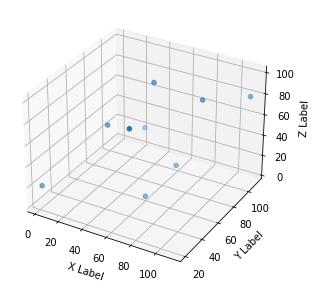

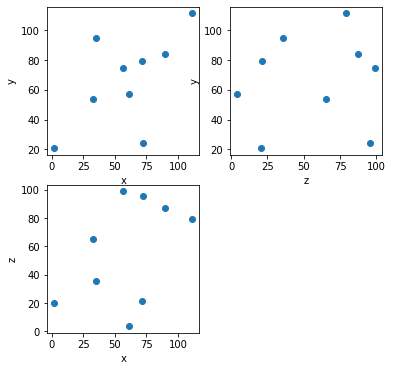

In [4]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.scatter(xs, ys)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2, 2, 2)
plt.scatter(zs, ys)
plt.xlabel('z')
plt.ylabel('y')

plt.subplot(2, 2, 3)
plt.scatter(xs, zs)
plt.xlabel('x')
plt.ylabel('z')

plt.show()

# Offline mode simulations

In [34]:
K = 10*N # number of trials
powers = np.arange(60, 111, 10) # available laser powers
sim.simulate(trials=K, powers=powers)

In [35]:
priors = {
    'alpha': 0.5 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 1e1 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[1e-1 * np.ones(N), 1e1 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e1]]) for _ in range(N)])
}

fit_options = {
    'iters': 100,
    'newton_steps': 20,
    'num_mc_samples': 10, 
    'verbose': False,
    'init_t': 1e1,
    't_loops': 3,
    't_mult': 15
}

model_offline = adaprobe.Model(sim.cell_locs, priors=priors, variational_model='omega-3d')

In [36]:
# Note: code must compile on first run, subtract 20 seconds from execution time.

%time model_offline.fit(sim.y, (sim.L, sim.I), fit_options=fit_options, method='cavi_offline_spike_and_slab_3d_omega')

CPU times: user 194 ms, sys: 4.33 ms, total: 198 ms
Wall time: 200 ms


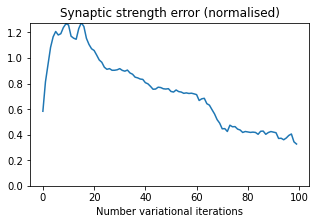

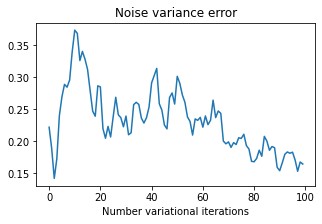

In [37]:
def plot_hist(model, sim):
    err = np.mean(np.square((model.history['mu'] - sim.w)/np.mean(np.abs(sim.w))), 1)
    plt.figure(figsize=(5, 3))
    plt.plot(err)
    plt.ylim([0, np.max(err)])
    plt.title('Synaptic strength error (normalised)')
    plt.xlabel('Number variational iterations')
    plt.show()
    
    plt.figure(figsize=(5, 3))
    plt.plot(np.mean(np.square(model.history['alpha'] - sim.z), 1))
    plt.title('Noise variance error')
    plt.xlabel('Number variational iterations')
    plt.show()
    
plot_hist(model_offline, sim)

## Plot synpatic strength posteriors

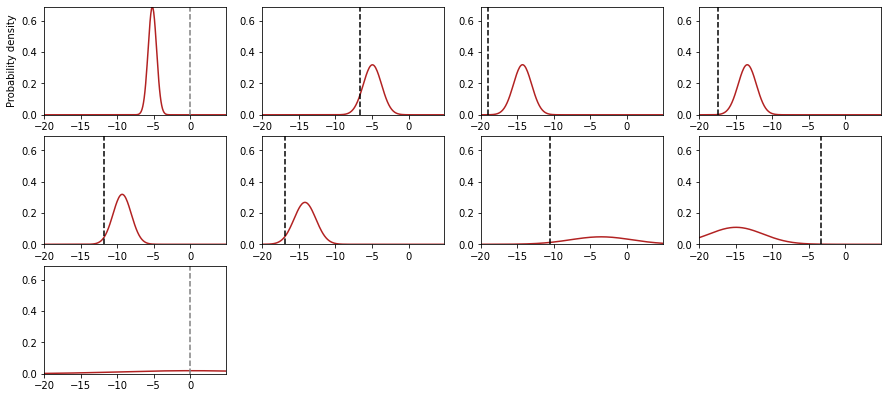

In [38]:
xrange = np.arange(-20, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, sim, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(model_offline, sim)

## Plot latent presynaptic spike posteriors

In [39]:
def plot_spike_pred(model, sim, xlim=None):
    spks = np.array(sim.spks).T.astype(float) # true simulated spikes
    fr = np.array(sim.fr).T # true simulated firing rates
    lam = np.array(model.state['lam']).T # inferred firing rate
    s_pred = (lam >= 0.5).astype(float) # spike prediction
    for n in range(N):
        plt.figure(figsize=(25, 0.75))
        if sim.w[n] == 0:
            plt.plot(fr[n], color='gray') # disconnected cell
        else:
            plt.plot(fr[n], color='k') # connected cell
        plt.plot(lam[n], '--', color='r')
        plt.scatter(np.arange(len(spks[n])), spks[n], color='gray')
        plt.scatter(np.arange(s_pred[0].shape[0]), s_pred[n], 50, marker='x', color='r')
        if xlim is not None:
            plt.xlim(xlim)
        else:
            plt.xlim([0, lam.shape[-1]])
        plt.ylim([0, 1.1])
        plt.show()

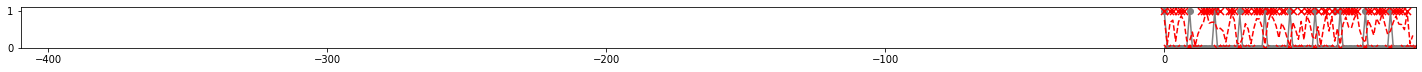

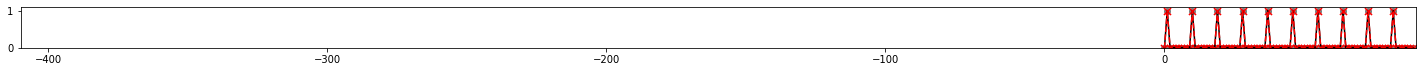

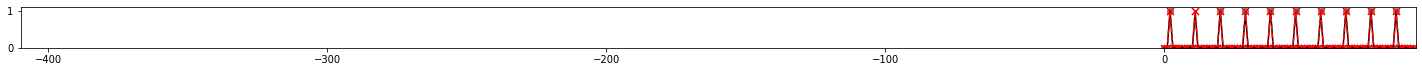

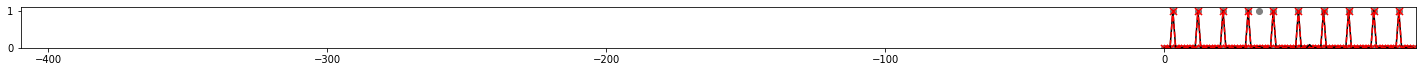

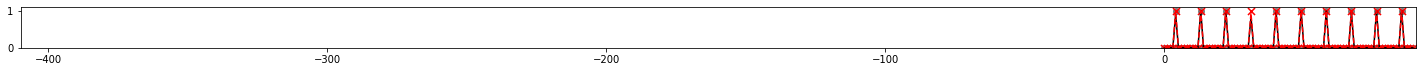

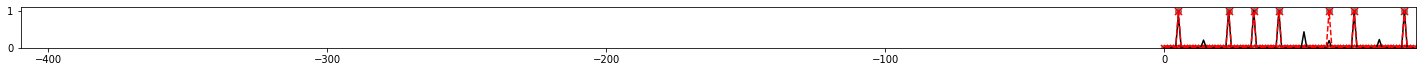

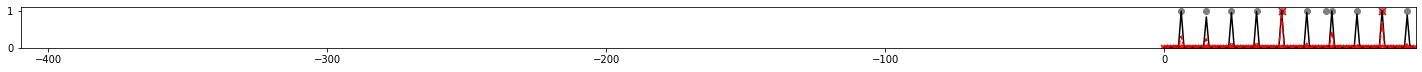

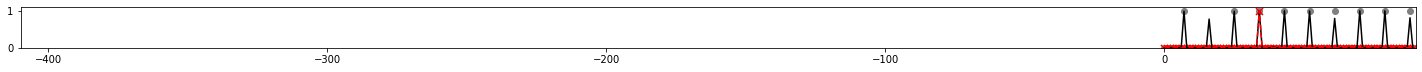

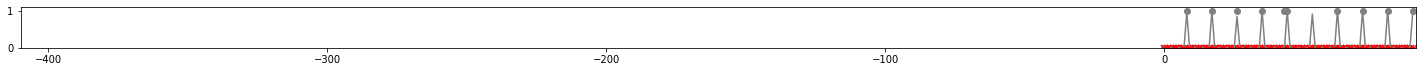

In [40]:
plot_spike_pred(model_offline, sim, xlim=[sim.trials - 500, sim.trials])

## Plot receptive field posteriors

In [41]:
def sigmoid(x): 
    return 1/(1 + np.exp(-x))

def plot_receptive_fields(model, sim, power):
    """Plot receptive fields of model over a given range.
    """
    phi_map = model.state['phi_map']
    phi_cov = model.state['phi_cov']
    Omega = model.state['Omega']
    
    xran = np.arange(0, 50, 0.01)
    locs = np.c_[xran, np.zeros(len(xran)), np.zeros(len(xran))]
    
    plt.figure(figsize=(14, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        power_atten = np.array([power * np.exp(-loc @ Omega[n] @ loc) for loc in locs])
        phi_0_lower = phi_map[n, 0] - np.sqrt(phi_cov[n][0, 0])
        phi_1_lower = phi_map[n, 1] - np.sqrt(phi_cov[n][1, 1])
        phi_0_upper = phi_map[n, 0] + np.sqrt(phi_cov[n][0, 0])
        phi_1_upper = phi_map[n, 1] + np.sqrt(phi_cov[n][1, 1])
        fn = sigmoid(phi_map[n, 0] * power_atten - phi_map[n, 1])
        fn_lower = sigmoid(phi_0_lower * power_atten - phi_1_lower)
        fn_upper = sigmoid(phi_0_upper * power_atten - phi_1_upper)

        if sim.z[n]:
            sim_col = 'k' # cell connected
        else:
            sim_col = 'gray' # cell not connected
        plt.plot(xran, sigmoid(sim.phi_0[n] * power_atten - sim.phi_1[n]), '--', color=sim_col)
        plt.plot(xran, fn, 'r')
        plt.fill_between(xran, fn_lower, fn_upper, alpha=0.35, facecolor='firebrick', edgecolor='None')
        plt.ylim([-0.5e-1, 1 + 0.5e-1])
        plt.ylim([-0.5e-1, 1 + 0.5e-1])
        if n == 0:
            plt.xlabel('Distance from soma in $x$')
            plt.ylabel('Spike probability (%i mw)'%power)
        plt.tight_layout()
    plt.show()

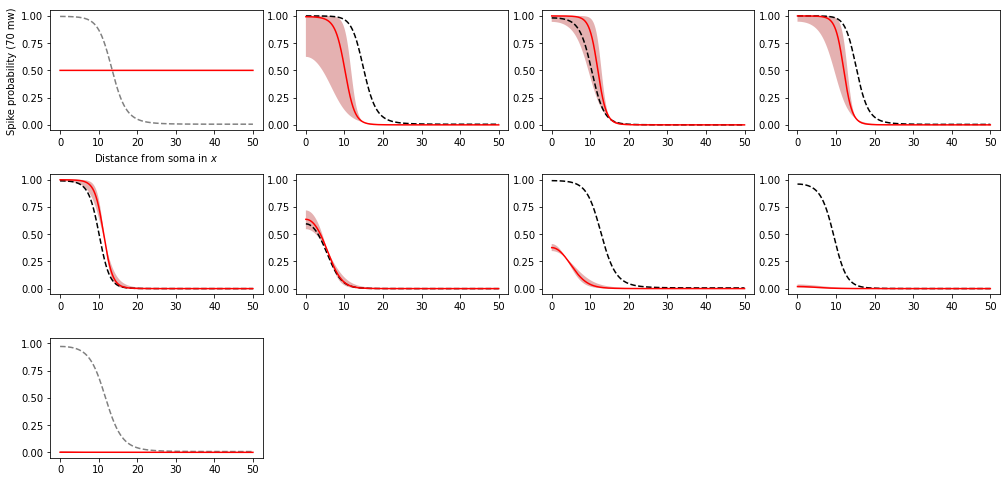

In [42]:
plot_receptive_fields(model_offline, sim, 70)

### What do posteriors look like with fewer trials?

In [14]:
model_offline_clipped = adaprobe.Model(sim.cell_locs, priors=priors, variational_model='omega-3d')

In [15]:
num_sample_trials = 50
%time model_offline_clipped.fit(sim.y[:num_sample_trials], (sim.L[:num_sample_trials], sim.I[:num_sample_trials]), fit_options=fit_options, method='cavi_offline_spike_and_slab_3d_omega')

CPU times: user 124 ms, sys: 4.03 ms, total: 128 ms
Wall time: 128 ms


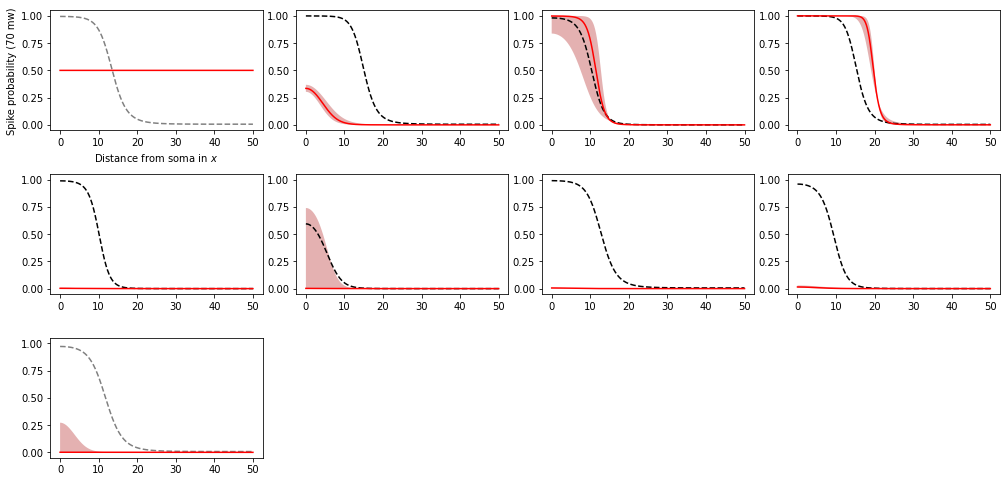

In [16]:
plot_receptive_fields(model_offline_clipped, sim, 70)

# Online mode simulations

In [17]:
# Some useful code for plotting convergence, not important...

def hist_to_errs(d, sim):
    errs = {}
    w_est = (np.array(d['mu']) * np.array(d['alpha'])).T
    sigma_est = np.sqrt(np.array(d['rate'])/np.array(d['shape']))
    phi_est = np.moveaxis(np.array(d['phi_map']), 0, -1)
    
    errs['w'] = np.mean(np.square(sim.w[:, None] - w_est)/np.mean(np.abs(sim.w)), 0)
    errs['sigma'] = np.abs(sim.sigma - sigma_est)
    errs['phi_0'] = np.abs(sim.phi_0[:, None] - phi_est[:, 0, :])
    errs['phi_1'] = np.abs(sim.phi_1[:, None] - phi_est[:, 1, :])
    
    return errs

def init_hist_dict(n_dicts=1, descriptors=[]):
    lsd = [{} for _ in range(n_dicts)]
    for d in lsd:
        for descr in descriptors:
            d[descr] = []
    if n_dicts == 1:
        return lsd[0]
    else:
        return lsd

def record_hist(d, model, umap=None, descriptors=[]):
    for descr in descriptors:
        d[descr] += [model.state[descr]]
        
descriptors = ['mu', 'beta', 'alpha', 'lam', 'phi_map', 'phi_cov', 'shape', 'rate']

In [18]:
interp = 1 # interpolation between prior and new posterior

priors_online = {
    'alpha': 0.5 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 2 * np.ones(N),
    'shape': 1,
    'rate': 1
}

fit_options_online = {
    'iters': 15,
    'newton_steps': 15, # default 10
    'lam_update': 'monte-carlo',
    'num_mc_samples': 10, # default 5
    'verbose': False,
    'init_t': 1e1,
    't_loops': 3, # default 3
    't_mult': 15,
    'interp': interp
}

ensemble_size = 5
models_online = [adaprobe.Model(sim.cell_locs, priors=priors_online, variational_model='omega-3d') for _ in range(ensemble_size)] # fit an ensemble of 5 models

In [19]:
sim.reset() # clear trials

In [20]:
hist = init_hist_dict(ensemble_size, descriptors=descriptors)
stimulus_jitter = 2

K_online = 3000

for e in range(ensemble_size):
    t1 = time.time()
    for k in range(K_online):
        print('trial %i/%i'%(k + 1, K_online), end='\r')
        tar = sim.cell_locs[np.mod(k, sim.N)] + np.random.normal(0, stimulus_jitter, 3) # jittered soma-targeting
        laser_power = np.random.choice(powers)
        sim.next_trial(tar, laser_power)
        models_online[e].update(sim.y[k], (sim.L[k], sim.I[k]), fit_options=fit_options_online, method='cavi_online_spike_and_slab_3d_omega')
        record_hist(hist[e], models_online[e], descriptors=descriptors)

    t2 = time.time()
    print('run %i: elapsed time %.2f'%(e+1, t2 - t1))

run 1: elapsed time 17.09
run 2: elapsed time 2.74
run 3: elapsed time 2.69
run 4: elapsed time 2.62
run 5: elapsed time 2.68


In [21]:
errs = [hist_to_errs(hist[e], sim) for e in range(ensemble_size)]
errs_mean = np.mean(np.array([errs[e]['w'] for e in range(ensemble_size)]), 0)
errs_sdev = np.std(np.array([errs[e]['w'] for e in range(ensemble_size)]), 0)

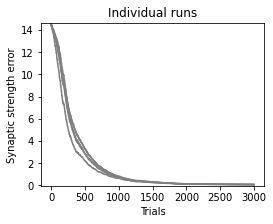

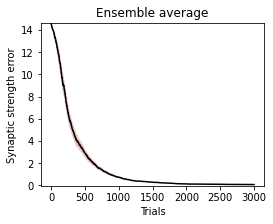

In [22]:
plt.figure(figsize=(4, 3))
for e in range(ensemble_size):
    plt.plot(errs[e]['w'], color='gray')
plt.title('Individual runs')
plt.ylabel('Synaptic strength error')
plt.xlabel('Trials')
plt.ylim([-0.05, np.max([errs[e]['w'] for e in range(ensemble_size)])])
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(errs_mean, color='k')
plt.title('Ensemble average')
plt.fill_between(np.arange(K_online), errs_mean-errs_sdev, errs_mean+errs_sdev, edgecolor='None', facecolor='firebrick', alpha=0.25)
plt.ylabel('Synaptic strength error')
plt.xlabel('Trials')
plt.ylim([-0.05, np.max(errs_mean)])
plt.show()

## Plot ensemble predictions

In [23]:
def plot_connections(models, sim, legend=[], save=None):
    plt.figure(figsize=(15, 3*(N/4)))
    gaussf_pop = [gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N) for model in models]
    postmax = np.max(np.array(gaussf_pop))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        for indx, model in enumerate(models):
            post = model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n])
            plt.plot(xrange, post)
            
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.legend(legend, loc='upper left', frameon=False)
    if save is not None:
        plt.savefig('figs/' + save + '.png', format='png', dpi=200, bbox_inches='tight')
    else:
        plt.show()

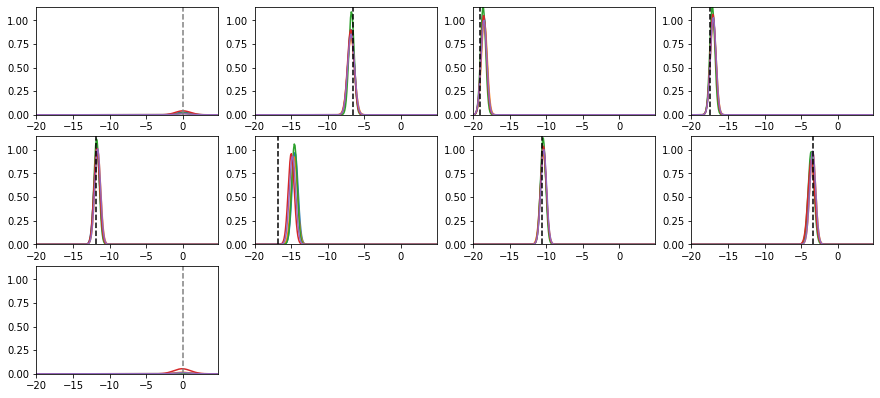

In [24]:
plot_connections(models_online, sim)